In [54]:
!pip install midv500

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import midv500
import pandas as pd
import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import logging
import skimage
from scipy import ndimage
from skimage import exposure, color
from skimage.transform import resize

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from keras.utils import to_categorical

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
dataset_dir = '/content/drive/MyDrive/Challenge'
img_dir = '/content/drive/MyDrive/Challenge/images-20221212T122934Z-001/images'
df_meta = pd.read_csv(os.path.join(dataset_dir,"gicsd_labels.csv"))

# Checking distribution of the dataset

In [58]:
df_meta.columns = df_meta.columns.str.strip()
df_meta.head(10)

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY
5,GICSD_1_3_93.png,FULL_VISIBILITY
6,GICSD_1_3_113.png,FULL_VISIBILITY
7,GICSD_1_4_133.png,FULL_VISIBILITY
8,GICSD_1_5_153.png,FULL_VISIBILITY
9,GICSD_1_5_173.png,FULL_VISIBILITY


In [59]:
df_meta.LABEL.value_counts()

 FULL_VISIBILITY        646
 PARTIAL_VISIBILITY     123
 NO_VISIBILITY           31
Name: LABEL, dtype: int64

In [60]:
#### configuring logging
formatter = logging.Formatter('[%(levelname)s] %(asctime)s: %(message)s')
# Configure stream handler for the cells
chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)
chandler.setFormatter(formatter)

# Add handler
logger = logging.getLogger()
logger.addHandler(chandler)
logger.setLevel(logging.INFO)

In [61]:
df_meta.LABEL= df_meta.LABEL.str.strip()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_meta['LABEL'])
logger.debug("encoded classes: %s", list(le.classes_))
df_meta['TARGET'] = le.transform(df_meta['LABEL'])
df_meta['BACKGROUND_ID'] = df_meta['IMAGE_FILENAME'].apply(lambda x: x.split("_")[2]).apply(lambda x: int(x))
df_meta['CARD_ID'] = df_meta['IMAGE_FILENAME'].apply(lambda x: x.split("_")[1]).apply(lambda x: int(x))
df_meta['IMAGE_ID'] = df_meta['IMAGE_FILENAME'].apply(lambda x: x.split("_")[3]).apply(lambda x: x.split(".")[0]).apply(lambda x: int(x))


df_meta.head(10)

,IMAGE_FILENAME,LABEL,TARGET,BACKGROUND_ID,CARD_ID,IMAGE_ID
0,GICSD_1_0_3.png,FULL_VISIBILITY,0,0,1,3
1,GICSD_1_0_13.png,FULL_VISIBILITY,0,0,1,13
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY,2,1,1,33
3,GICSD_1_1_53.png,FULL_VISIBILITY,0,1,1,53
4,GICSD_1_2_73.png,FULL_VISIBILITY,0,2,1,73
5,GICSD_1_3_93.png,FULL_VISIBILITY,0,3,1,93
6,GICSD_1_3_113.png,FULL_VISIBILITY,0,3,1,113
7,GICSD_1_4_133.png,FULL_VISIBILITY,0,4,1,133
8,GICSD_1_5_153.png,FULL_VISIBILITY,0,5,1,153
9,GICSD_1_5_173.png,FULL_VISIBILITY,0,5,1,173


[Text(0, 0, 'full visibility'),
 Text(0, 0, 'no visibility'),
 Text(0, 0, 'partial visibility')]

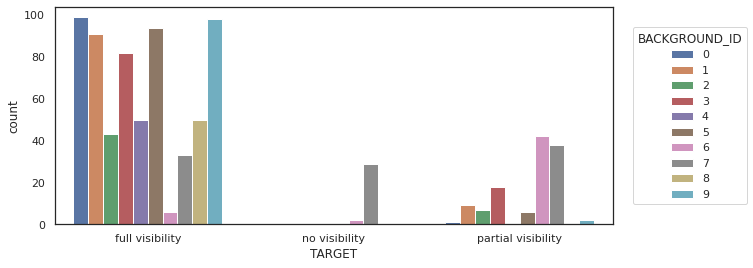

In [62]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(x="TARGET", hue="BACKGROUND_ID", data=df_meta, dodge = True)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, title="BACKGROUND_ID")
ticklabels=['full visibility', 'no visibility', 'partial visibility']
ax.xaxis.set_ticklabels(ticklabels)

Basically the dataset already provides some sort of 'embedded' augmentation, as there are 16 different shots for each id. For this reason.
When applying augmentation, we will use small parameters for rotation and horizonal, vertical shift, which would ensure we do not change target class;
As a possible improvement to the model, we can include background and card id in a separate input channel.

In [63]:
#checking the images

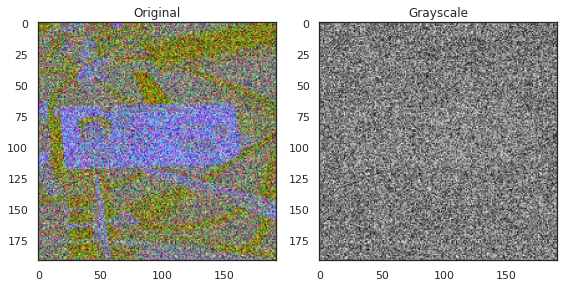

In [64]:
sns.set(style="white")
img = plt.imread(os.path.join(img_dir, df_meta.IMAGE_FILENAME[0]))
grayscale_img1 = color.rgb2gray(img)

def plot_img1_vs_img2(img1, img2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax = axes.ravel()
    ax[0].imshow(img1, cmap=plt.cm.gray)
    ax[0].set_title(title1)
    ax[1].imshow(img2, cmap=plt.cm.gray)
    ax[1].set_title(title2)

    fig.tight_layout()
    plt.show()
    
plot_img1_vs_img2(img, grayscale_img1, "Original", "Grayscale")

The resultant image is a white noise, we have to check each channel i.e. R,G,B seperately to see weather any of the channel shows something

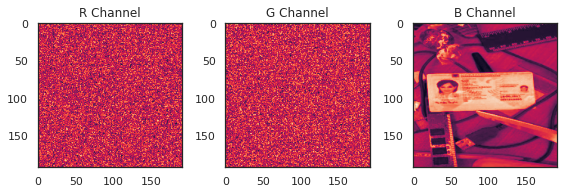

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(img[:,:,0])
ax[0].set_title("R Channel")
ax[1].imshow(img[:,:,1])
ax[1].set_title("G Channel")
ax[2].imshow(img[:,:,2])
ax[2].set_title("B Channel")

fig.tight_layout()
plt.show()

We can see the image in the B channel. Let's convert it in grayscale for better visualization

Text(0.5, 1.0, 'B channel in Grayscale')

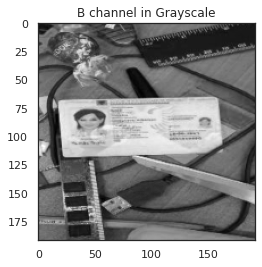

In [66]:
plt.imshow(img[:,:,2], cmap=plt.cm.gray)
plt.title("B channel in Grayscale")

In [67]:
from collections import Counter
result = []
for id in range(df_meta.IMAGE_FILENAME.shape[0]):
    img = plt.imread(os.path.join(img_dir, df_meta.IMAGE_FILENAME[id]))
    median_channel_corr = {'R': abs(np.median(np.corrcoef(img[:,:,0]))), 'G': abs(np.median(np.corrcoef(img[:,:,1]))), 'B': abs(np.median(np.corrcoef(img[:,:,2])))}
    #print(median_channel_corr)
    result.append(max(median_channel_corr.keys(), key=(lambda key: median_channel_corr[key])))
    if result[id] != 'B': 
        logger.info("max correlation for img %d is not for channel 'B'", id)

logger.info("count of images detected per channel: %s", Counter(result))

INFO:root:max correlation for img 157 is not for channel 'B'
[INFO] 2022-12-14 10:12:08,253: max correlation for img 157 is not for channel 'B'
[INFO] 2022-12-14 10:12:08,253: max correlation for img 157 is not for channel 'B'
INFO:root:max correlation for img 293 is not for channel 'B'
[INFO] 2022-12-14 10:12:10,077: max correlation for img 293 is not for channel 'B'
[INFO] 2022-12-14 10:12:10,077: max correlation for img 293 is not for channel 'B'
INFO:root:max correlation for img 369 is not for channel 'B'
[INFO] 2022-12-14 10:12:11,778: max correlation for img 369 is not for channel 'B'
[INFO] 2022-12-14 10:12:11,778: max correlation for img 369 is not for channel 'B'
INFO:root:max correlation for img 433 is not for channel 'B'
[INFO] 2022-12-14 10:12:13,522: max correlation for img 433 is not for channel 'B'
[INFO] 2022-12-14 10:12:13,522: max correlation for img 433 is not for channel 'B'
INFO:root:count of images detected per channel: Counter({'B': 796, 'R': 3, 'G': 1})
[INFO] 2

In [68]:
def to_one_channel(img):
    """ Convert an RGB image to one channel image.
    
    :param img: numpy nd-array - input image.

    :return: numpy nd-array - output image.
    """
    return img[:,:,2]


In [69]:
from skimage import exposure, color
from skimage.transform import resize

def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

# Histogram equalization
def HE(img):
    img_eq = exposure.equalize_hist(img)
    return img_eq

# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

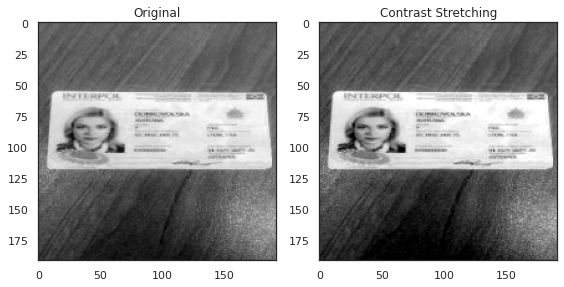

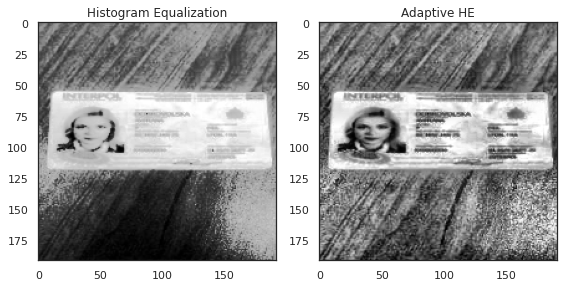

In [70]:
img_cs = contrast_stretching(to_one_channel(img))
img_he = HE(to_one_channel(img))
img_ahe = AHE(to_one_channel(img))
plot_img1_vs_img2(to_one_channel(img), img_cs, "Original", "Contrast Stretching")
plot_img1_vs_img2(img_he, img_ahe, "Histogram Equalization", "Adaptive HE")

Inspecting the transformations above visually suggests that contrast stretching helps to distinguish between the background and the id card better than in the original image, it also doesn't distorting the information on the ID.Therefore it looks like a good approach to apply as part of image preprocessing.

In [71]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_meta.IMAGE_FILENAME, df_meta.TARGET, test_size=0.25, random_state=0, shuffle=True, stratify=df_meta['TARGET'])

In [72]:
df_train= df_meta.loc[x_train.index.tolist()]
df_train.shape

(600, 6)

In [73]:
def _oversample_positives(df, target):
    """ Oversample the minority classes to match
    the majority class.
    
    :param df: pandas dataframe - input df.
    :param target: string - classification target column.

    :return: pandas datframe - oversampled version
    """

    class_count = df[target].value_counts()

    print("Before oversampling: %s" % class_count)
    for i in range(1,len(class_count)):
        df_i = df[df[target] == i]
        oversampling_factor_i = class_count[0] / float(class_count[i])
        print(len(df_i))
        print("Oversampling factor for class %i: %s" %(i, str(oversampling_factor_i)))
    
        # Integer part of oversampling
        df = df.append(
            [df_i] * int(math.floor(oversampling_factor_i) - 1),
            ignore_index=False)
        # Float part of oversampling
        df = df.append(
            [df_i.sample(frac=oversampling_factor_i % 1)],
            ignore_index=False)
    
    print("After oversampling: %s" % df[target].value_counts())
    print("Shape after oversampling: %s" % str(df.shape))

    return df

In [74]:
df_train_oversampled = _oversample_positives(df_train, "TARGET")

Before oversampling: 0    485
2     92
1     23
Name: TARGET, dtype: int64
23
Oversampling factor for class 1: 21.08695652173913
92
Oversampling factor for class 2: 5.271739130434782
After oversampling: 0    485
2    485
1    485
Name: TARGET, dtype: int64
Shape after oversampling: (1455, 6)


In [78]:
x_train_oversampled = df_train_oversampled["IMAGE_FILENAME"]
y_train_oversampled = df_train_oversampled["TARGET"]

In [81]:
import keras
from keras.models import Sequential,Model
from keras.layers import Concatenate, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50

def get_model():
   
    base_model = ResNet50(weights='imagenet',include_top=False,input_shape= (192, 192, 3) ) 

    add_model = Sequential()
    add_model.add(Flatten())
    add_model.add(Dense(256, activation='relu', input_dim=6 * 6 * 2048))
    add_model.add(Dropout(0.50))   
    add_model.add(Dense(128, activation='relu')) 
    add_model.add(Dropout(0.50))  
    add_model.add(Dense(64, activation='relu'))    
    add_model.add(Dense(3, activation='softmax'))
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    print(base_model.output)
    adam = keras.optimizers.Adam(lr=0.0005)
    model.compile(loss='categorical_crossentropy',metrics=['acc'],
                  optimizer=adam)
    return model

In [82]:
model = get_model()
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   94

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 24, 24, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 24, 24, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 24, 24, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 24, 24, 512)  131584      ['conv2_block3_out[0][0]']       
          

In [83]:
X_train_images = []
for file in x_train_oversampled:
    train_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    train_img = np.stack((train_img,)*3, axis=-1)
    train_img = contrast_stretching(train_img)
    X_train_images.append(train_img)
X_train_images = np.array(X_train_images)

In [84]:
X_train_images.shape

(1455, 192, 192, 3)

In [85]:
# converting to one-hot-encoding required by categorical_crossentropy loss
y_train_binary = to_categorical(y_train_oversampled)

In [86]:
X_test_images = []
for file in x_test:
    test_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    test_img = np.stack((test_img,)*3, axis=-1)
    test_img = contrast_stretching(test_img)
    X_test_images.append(test_img)
X_test_images = np.array(X_test_images)

In [87]:
datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=[-2, 2],
    height_shift_range=[-5, 5])

In [ ]:
model.fit_generator(datagen.flow(X_train_images, y_train_binary, batch_size=32), verbose = 1, epochs=35, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/35
46/46 [==============================] - 839s 18s/step - loss: 1.8335 - acc: 0.5993
Epoch 2/35
46/46 [==============================] - 834s 18s/step - loss: 0.5565 - acc: 0.8089
Epoch 3/35
46/46 [==============================] - 833s 18s/step - loss: 0.5819 - acc: 0.8612
Epoch 4/35
46/46 [==============================] - 811s 18s/step - loss: 0.4956 - acc: 0.8756
Epoch 5/35
46/46 [==============================] - 818s 18s/step - loss: 0.3288 - acc: 0.8962
Epoch 6/35
46/46 [==============================] - 815s 18s/step - loss: 0.2374 - acc: 0.9306
Epoch 7/35
46/46 [==============================] - 823s 18s/step - loss: 0.1164 - acc: 0.9615
Epoch 8/35
46/46 [==============================] - 822s 18s/step - loss: 0.1195 - acc: 0.9677
Epoch 9/35
46/46 [==============================] - 820s 18s/step - loss: 0.1016 - acc: 0.9691
Epoch 10/35
46/46 [==============================] - 815s 18s/step - loss: 0.0962 - acc: 0.9698
Epoch 11/35
46/46 [==============================

In [3]:
predictions = model.predict(X_test_images)
predictions[0:5]

NameError: ignored

In [4]:
#converting predictions to a single number
predictions_num = np.argmax(predictions, axis=1)
predictions_num

NameError: ignored

In [5]:
class_map = {0:"FULL_VISIBILITY", 1:"NO_VISIBILITY", 2:"PARTIAL_VISIBILITY"}
class_map[predictions_num[0]]

NameError: ignored

In [ ]:
# Check AUC of the model
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_num, pos_label=2)
auc = metrics.auc(fpr, tpr)
f1_score = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average=None)
f1_score_weighted = metrics.f1_score(y_true = y_test, y_pred = predictions_num, average='weighted')
print("auc = %f" % auc)
print("f1_score_weighted = %s" % f1_score_weighted)
print("f1_score = %s" % f1_score)


In [ ]:
cm = metrics.confusion_matrix(y_test, predictions_num)

plt.figure(figsize=(7,7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=12);
ax.set_ylabel('True Labels', size=12); 
ax.set_title('AUC, oversampl, augm, 35epoch: {:.3f}'.format(auc), size=14); 
ticklabels=['full visibility', 'no visibility', 'partial']
ax.xaxis.set_ticklabels(ticklabels); 
ax.yaxis.set_ticklabels(ticklabels);

In [ ]:
df_prod_oversampled = _oversample_positives(df_meta, "TARGET")
x_prod_oversampled = df_prod_oversampled["IMAGE_FILENAME"]
y_prod_oversampled = df_prod_oversampled["TARGET"]

In [ ]:
X_prod_images = []
for file in x_prod_oversampled:
    prod_img = to_one_channel(plt.imread(os.path.join(img_dir, file)))
    prod_img = np.stack((prod_img,)*3, axis=-1)
    prod_img = contrast_stretching(prod_img)
    X_prod_images.append(prod_img)
X_prod_images = np.array(X_prod_images)

In [ ]:
y_prod_binary = to_categorical(y_prod_oversampled)

In [ ]:
model.fit_generator(datagen.flow(X_prod_images, y_prod_binary, batch_size=32), verbose = 1, epochs=35, shuffle=True)

In [ ]:
# saving the model
model.save('prod_resnet50_oversampling_model.h5')  
